In [1]:
import sys
import os
workPath = os.path.abspath('..')
if not workPath in sys.path:
    sys.path.append(workPath)

In [2]:
from timeit import timeit
import numpy as np
from scipy import stats
import pandas as pd
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn import linear_model
import numpy as np
def regress(dataFrame, xs, y, keytuple = None, rounding = 2, intercept = True):
    lmOut = []
    lm = linear_model.LinearRegression(fit_intercept = True)
    if type(xs) == str:
        xs = [xs,]
    if not keytuple is None:
        key, keyval = keytuple
        dataFrame = dataFrame.loc[dataFrame[key] == keyval]
    dataXs = list(zip(*[dataFrame[x] for x in xs]))
    dataY = dataFrame[y]
    lm.fit(dataXs, dataY)
    lmOut = [np.round(item, rounding) for item in (lm.coef_, lm.intercept_, lm.score(dataXs, dataY))]
    lmOut[0] = list(lmOut[0])
    header = y + " vs " + str(xs) + '; coef, intercept, score:'
    return header, lmOut
def regress_series(dataFrame, xs, y, key, rounding = 2, intercept = True):
    outList = []
    header = ''
    for keyval in sorted(set(dataFrame[key])):
        header, datarow = regress(
            dataFrame,
            xs,
            y,
            keytuple = (key, keyval),
            rounding = rounding,
            intercept = intercept
            )
        outList.append((round(keyval, rounding), datarow))
    header = key + "; " + header
    return header, outList

In [3]:
from everest import window
from everest import _specialnames
Fetch = window.Fetch
Reader = window.Reader

In [4]:
projName = 'arrbench16'
outputPath = os.path.join(*['..', 'out', 'analysis', projName])
filePath = os.path.join(outputPath, projName + '.h5')

In [5]:
myreader = Reader(filePath)

In [6]:
filterScope = myreader[Fetch('Nu') > 0.]
attrDict = myreader.view_attrs(filterScope)

/home/jovyan/workspace/everest/window.py:136: RuntimeWarning: invalid value encountered in greater
  outVal = self.operations[self.operation](*args)


In [7]:
np.round(np.log10(sorted((attrDict['Ra'].keys()))), 1)

array([3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5])

In [8]:
np.round(np.log10(sorted((attrDict['eta0'].keys()))), 1)

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5])

In [9]:
sorted((attrDict['f'].keys()))

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [10]:
fs = sorted(attrDict['f'].keys())[2:]
Ras = sorted(attrDict['Ra'].keys())[:6]
eta0s = sorted(attrDict['eta0'].keys())

allData = []

for f in fs:
    fScope = attrDict['f'][f]
    for Ra in Ras:
        RaScope = attrDict['Ra'][Ra]
        for eta0 in eta0s:
            etaScope = attrDict['eta0'][eta0]
            thisScope = fScope * RaScope * etaScope
            Nus, modeltimes = myreader.pull(thisScope, ('Nu', 'modeltime'))
            recentNus, recentModeltimes = Nus[-100:], modeltimes[-100:]
            intervals = np.diff(recentModeltimes)
            NuAv = np.average(recentNus[1:], weights = intervals)
            allDataRow = (f, Ra, eta0, NuAv)
            allData.append(allDataRow)

allData = [row for row in allData if row[-1] < 10]

allData = np.array(allData)
fs, Ras, eta0s, NuAvs = allData.T

In [70]:
allDataFrame = pd.DataFrame(allData, columns = ['fs', 'Ras', 'eta0s', 'NuAvs'])
allDataFrame['Raf2'] = allDataFrame['Ras'] * allDataFrame['fs'] ** 2
allDataFrame['logNuAvs'] = np.log(allDataFrame['NuAvs'])
allDataFrame['logRaf2'] = np.log(allDataFrame['Raf2'])
allDataFrame['logEta0s'] = np.log(allDataFrame['eta0s'])
allDataFrame['log10NuAvs'] = np.log10(allDataFrame['NuAvs'])
allDataFrame['log10Raf2'] = np.log10(allDataFrame['Raf2'])
allDataFrame['log10Eta0s'] = np.log10(allDataFrame['eta0s'])

In [71]:
allDataFrame

,fs,Ras,eta0s,NuAvs,Raf2,logNuAvs,logRaf2,logEta0s,log10NuAvs,log10Raf2,log10Eta0s
0,0.3,1000.0,10.0,1.017259,90.0,0.017111,4.499810,2.302585,0.007431,1.954243,1.000000
1,0.3,1000.0,32.0,1.017259,90.0,0.017112,4.499810,3.465736,0.007432,1.954243,1.505150
2,0.3,1000.0,100.0,1.017260,90.0,0.017112,4.499810,4.605170,0.007432,1.954243,2.000000
3,0.3,1000.0,316.0,1.017260,90.0,0.017112,4.499810,5.755742,0.007432,1.954243,2.499687
4,0.3,1000.0,1000.0,1.017260,90.0,0.017112,4.499810,6.907755,0.007432,1.954243,3.000000
...,...,...,...,...,...,...,...,...,...,...,...
473,1.0,316228.0,3162.0,2.692902,316228.0,0.990619,12.664219,8.058960,0.430221,5.500000,3.499962
474,1.0,316228.0,10000.0,2.331052,316228.0,0.846320,12.664219,9.210340,0.367552,5.500000,4.000000
475,1.0,316228.0,31623.0,2.104113,316228.0,0.743894,12.664219,10.361640,0.323069,5.500000,4.500003
476,1.0,316228.0,100000.0,1.942216,316228.0,0.663830,12.664219,11.512925,0.288298,5.500000,5.000000


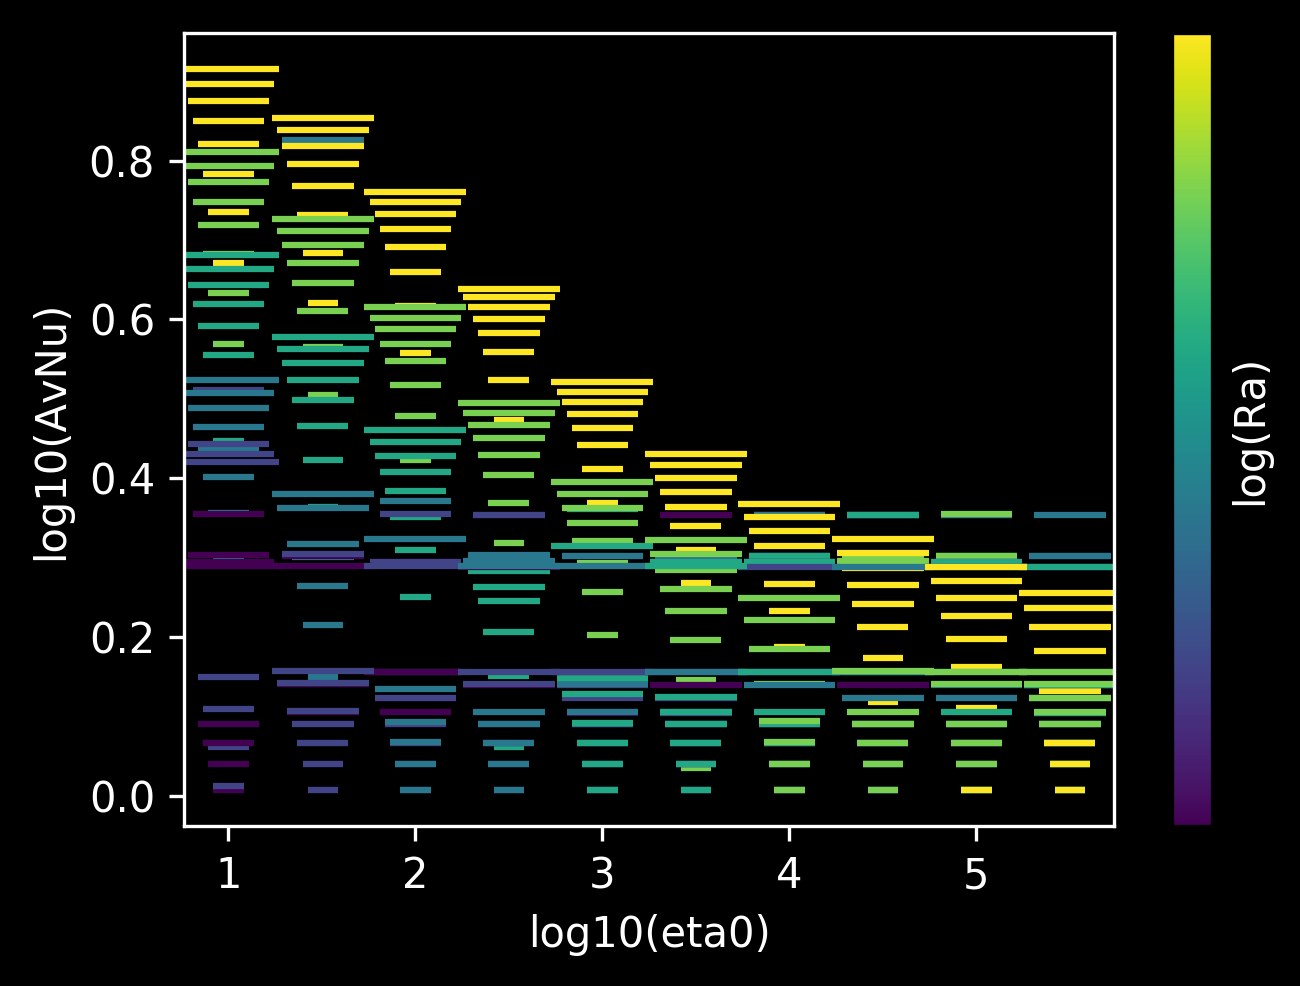

In [211]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (5., 3.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax.set_xlabel('log10(eta0)')
ax.set_ylabel('log10(AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

logRas = np.log10(Ras)

cmap = plt.get_cmap('viridis')
norm = mpl.colors.Normalize(
    vmin = np.min(logRas),
    vmax = np.max(logRas)
    )

scatter = ax.scatter(
    np.log10(eta0s),
    np.log10(NuAvs),
    c = norm(logRas),
    cmap = cmap,
    s = 600. * fs ** 2,
    edgecolor = 'white',
    alpha = 1.,
    marker = '_'
    )

cbar = plt.colorbar(scatter)
cbarticks = cbar.set_ticks(logRas)
cbar.ax.yaxis.set_tick_params(color = 'white')
cbar.set_label('log(Ra)', color = 'white')
ignoreme = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'white')

# for val in sorted(set(subFrame['logRaf2'])):
#     subsubFrame = subFrame.loc[subFrame['logRaf2'] == val]
#     xs = subsubFrame['log10Eta0s']
#     ys = subsubFrame['log10NuAvs']
#     zs = np.polyfit(xs, ys, 1)
#     p = np.poly1d(zs)
#     if regressionDict[round(val, 2)][2] > 0.9:
#         plt.plot(xs, p(xs), "w", alpha = 0.5)

In [161]:
eta0_regression_header, eta0_regression = regress_series(allDataFrame, 'logEta0s', 'logNuAvs', key = 'logRaf2')
eta0_regression_dict = dict(eta0_regression)
eta0_regression_filtered = [row for row in eta0_regression if row[1][2] > 0.9]
eta0_regression_filtered_dict = dict(eta0_regression_filtered)

In [103]:
eta0_regression_filtered_dict

{9.68: [[-0.15], 1.72, 0.92],
 10.13: [[-0.15], 1.84, 0.93],
 10.26: [[-0.16], 1.97, 0.99],
 10.49: [[-0.16], 1.92, 0.93],
 10.83: [[-0.16], 2.11, 0.99],
 11.28: [[-0.17], 2.21, 0.99],
 11.3: [[-0.15], 2.05, 0.94],
 11.51: [[-0.16], 2.12, 0.95],
 11.64: [[-0.16], 2.27, 0.98],
 11.95: [[-0.16], 2.31, 0.97],
 12.22: [[-0.16], 2.35, 0.97],
 12.45: [[-0.16], 2.38, 0.97],
 12.66: [[-0.16], 2.41, 0.96]}

In [108]:
averageGoodSlope = np.average([row[1][0][0] for row in eta0_regression_filtered])
averageGoodSlopeScore = np.average([row[1][2] for row in eta0_regression_filtered])
(averageGoodSlope, averageGoodSlopeScore)

(-0.15846153846153843, 0.9607692307692309)

Text(0.5, 1.0, '(average slope, score > 0.9 = -0.16)')

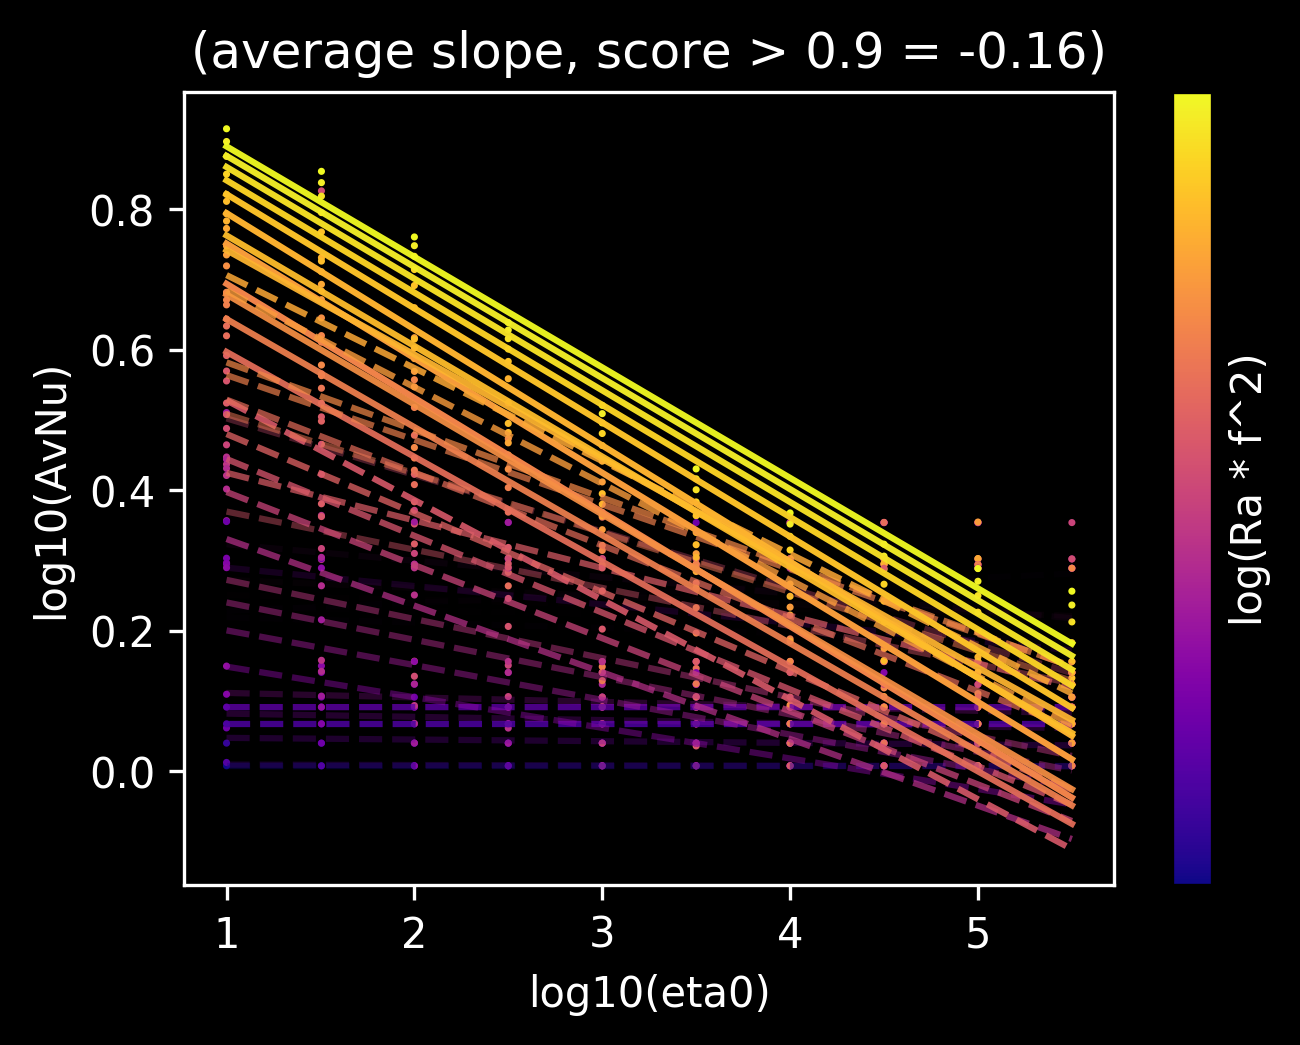

In [212]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (5., 3.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax.set_xlabel('log10(eta0)')
ax.set_ylabel('log10(AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

cSet = subFrame['logRaf2']

cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(
    vmin = np.min(cSet),
    vmax = np.max(cSet)
    )

scatter = ax.scatter(
    subFrame['log10Eta0s'],
    subFrame['log10NuAvs'],
    c = norm(np.array(cSet)),
    cmap = cmap,
    s = 0.5,
#     edgecolor = 'white',
#     alpha = 0.1,
    )

cbar = plt.colorbar(scatter, alpha = 1.)
cbarticks = cbar.set_ticks(logRas)
cbar.ax.yaxis.set_tick_params(color = 'white')
cbar.set_label('log(Ra * f^2)', color = 'white')
ignoreme = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'white')

for val in sorted(set(subFrame['logRaf2'])):
    subsubFrame = subFrame.loc[subFrame['logRaf2'] == val]
    xs = subsubFrame['log10Eta0s']
    ys = subsubFrame['log10NuAvs']
    zs = np.polyfit(xs, ys, 1)
    p = np.poly1d(zs)
    score =  eta0_regression_dict[round(val, 2)][2]
    if score > 0.9:
        linestyle = '-'
    else:
        linestyle = '--'
    alpha = score
    plt.plot(
        xs,
        p(xs),
        color = cmap(norm(val)),
        alpha = alpha,
        linestyle = linestyle
        )

plt.title("(average slope, score > 0.9 = %.2f)"%averageGoodSlope)

In [137]:
eta0_regression_filtered

[(9.68, [[-0.15], 1.72, 0.92]),
 (10.13, [[-0.15], 1.84, 0.93]),
 (10.26, [[-0.16], 1.97, 0.99]),
 (10.49, [[-0.16], 1.92, 0.93]),
 (10.83, [[-0.16], 2.11, 0.99]),
 (11.28, [[-0.17], 2.21, 0.99]),
 (11.3, [[-0.15], 2.05, 0.94]),
 (11.51, [[-0.16], 2.12, 0.95]),
 (11.64, [[-0.16], 2.27, 0.98]),
 (11.95, [[-0.16], 2.31, 0.97]),
 (12.22, [[-0.16], 2.35, 0.97]),
 (12.45, [[-0.16], 2.38, 0.97]),
 (12.66, [[-0.16], 2.41, 0.96])]

In [178]:
logRaf2s = [row[0] for row in eta0_regression_filtered]
intercepts = [row[1][1] for row in eta0_regression_filtered]
slope, intercept, rvalue, pvalue, stderr = stats.linregress(logRaf2s, intercepts)
print("Slope: ", round(slope, 2), ", score: ", round(rvalue, 2), ", intercept: ", round(intercept, 2))

Slope:  0.23 , score:  0.97 , intercept:  -0.42


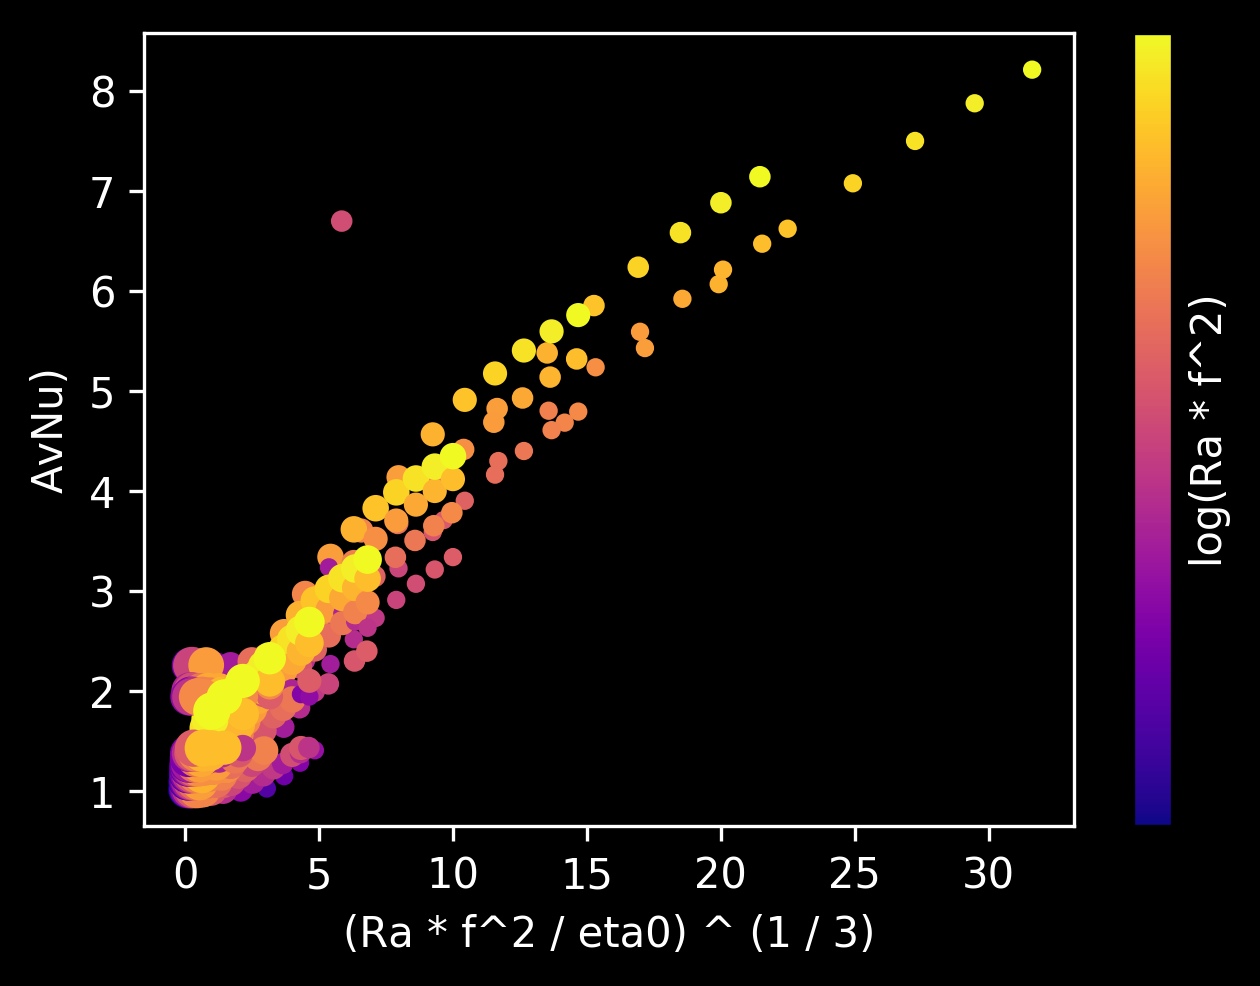

In [213]:
subFrame = allDataFrame

mpl.rcParams.update({
    'text.color': "white",
    'axes.labelcolor': "white"
    })

fig = plt.figure(facecolor = 'black', edgecolor = 'black', figsize = (5., 3.5), dpi = 300)
fig.add_axes()
ax = fig.add_subplot(111)
ax.set_facecolor('black')
# ax.grid(color = 'grey', linestyle = '-', linewidth = 2)
ax.tick_params(color = 'white', labelcolor = 'white')
for spine in ax.spines.values():
    spine.set_edgecolor('white')

ax.set_xlabel('(Ra * f^2 / eta0) ^ (1 / 3)')
ax.set_ylabel('AvNu)')
# ax.set_xlim((0, 16))
# ax.set_ylim((0, 3))

cSet = subFrame['logRaf2']
cmap = plt.get_cmap('plasma')
norm = mpl.colors.Normalize(
    vmin = np.min(cSet),
    vmax = np.max(cSet)
    )

scatter = ax.scatter(
    (subFrame['Raf2'] / subFrame['eta0s']) ** (1. / 3.),
    subFrame['NuAvs'],
    c = norm(np.array(cSet)),
    cmap = cmap,
    s = 5. * subFrame['logEta0s'],
#     edgecolor = 'white',
#     alpha = 0.1,
    )

cbar = plt.colorbar(scatter)
cbarticks = cbar.set_ticks(logRas)
cbar.ax.yaxis.set_tick_params(color = 'white')
cbar.set_label('log(Ra * f^2)', color = 'white')
ignoreme = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color = 'white')

In [214]:
allDataFrame['THEORETICALSCALING'] = (allDataFrame['Raf2'] / allDataFrame['eta0s']) ** (1. / 3.)

In [215]:
regress(allDataFrame, 'THEORETICALSCALING', 'NuAvs')

("NuAvs vs ['THEORETICALSCALING']; coef, intercept, score:",
 [[0.26], 1.18, 0.88])

In [174]:
allDataFrame['Raf2/eta0'] = allDataFrame['Raf2'] / allDataFrame['eta0s']
allDataFrame['log(Raf2/eta0)'] = np.log(allDataFrame['Raf2/eta0'])
allDataFrame['Raf2/sqrteta0'] = allDataFrame['Raf2'] / np.sqrt(allDataFrame['eta0s'])
allDataFrame['log(Raf2/sqrteta0)'] = np.log(allDataFrame['Raf2/sqrteta0'])

In [175]:
regress_series(allDataFrame, 'log(Raf2/eta0)', 'logNuAvs', 'eta0s')

("eta0s; logNuAvs vs ['log(Raf2/eta0)']; coef, intercept, score:",
 [(10.0, [[0.27], -0.6, 0.95]),
  (32.0, [[0.27], -0.5, 0.89]),
  (100.0, [[0.24], -0.23, 0.88]),
  (316.0, [[0.18], 0.1, 0.76]),
  (1000.0, [[0.15], 0.21, 0.73]),
  (3162.0, [[0.11], 0.34, 0.58]),
  (10000.0, [[0.06], 0.42, 0.19]),
  (31623.0, [[0.05], 0.47, 0.18]),
  (100000.0, [[0.04], 0.47, 0.1]),
  (316228.0, [[0.03], 0.39, 0.09])])

In [176]:
regress(allDataFrame, 'log(Raf2/eta0)', 'logNuAvs')

("logNuAvs vs ['log(Raf2/eta0)']; coef, intercept, score:",
 [[0.1], 0.46, 0.58])

In [177]:
regress(allDataFrame, 'log(Raf2/sqrteta0)', 'logNuAvs')

("logNuAvs vs ['log(Raf2/sqrteta0)']; coef, intercept, score:",
 [[0.15], -0.15, 0.63])